# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab

Dataset shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor labels: (3064,)
Unique labels: [0 1 2]


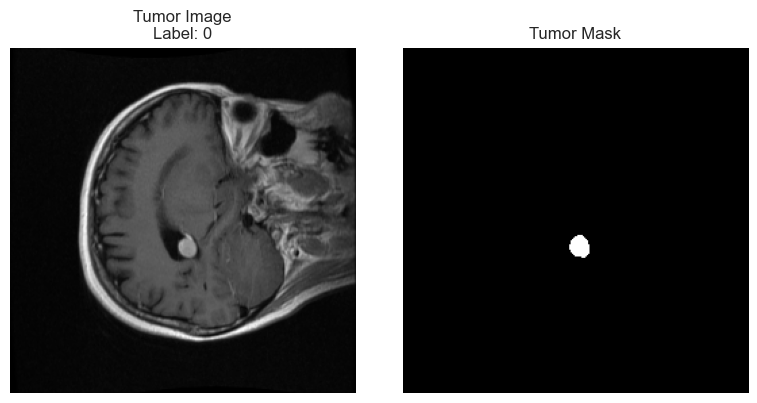

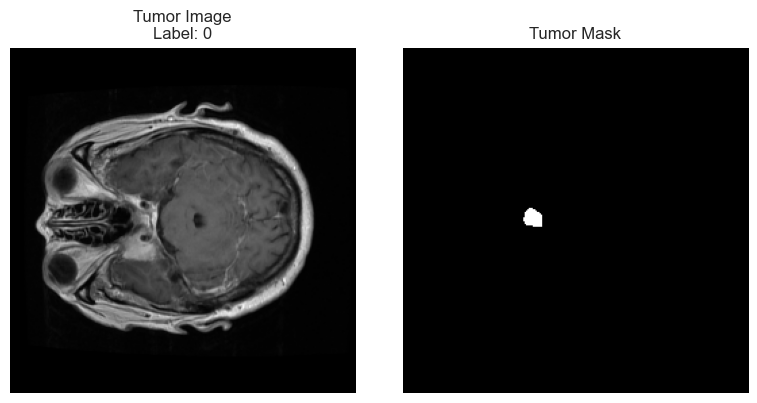

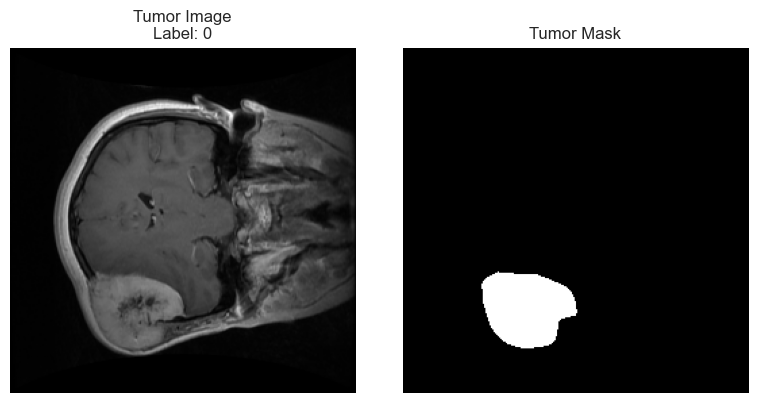

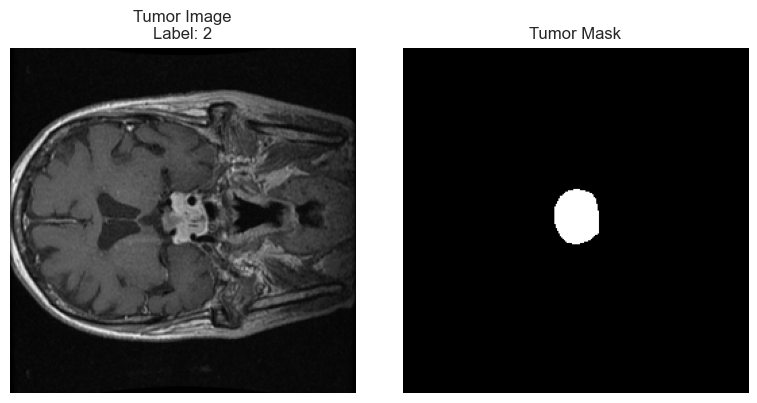

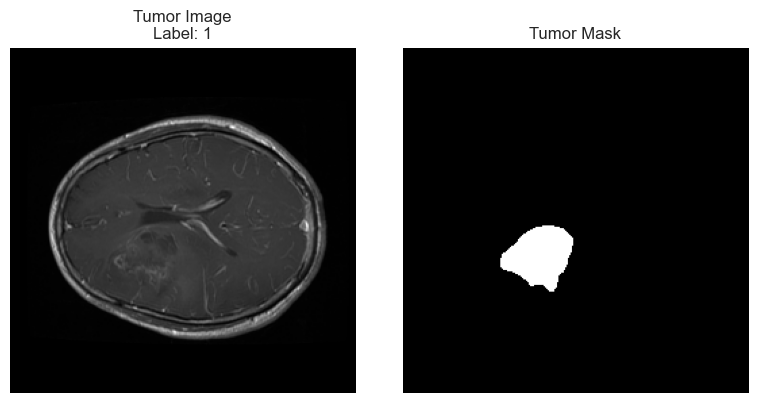

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Pytorch Lightning modules

# 4.1 Lightning module for multi task models

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# torch.manual_seed(42)

# dataset class
class BrainTumorDataset_multi(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule_multi(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset_multi(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module_multi = BrainTumorDataModule_multi(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module_multi.setup()

# initialize loaders
train_loader_multi = data_module_multi.train_dataloader()
test_loader_multi = data_module_multi.test_dataloader()
for batch in train_loader_multi:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader_multi:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 4.2 Lightning module for Seg only model

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# torch.manual_seed(42)

# dataset class
class BrainTumorDataset_seg(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # make images and masks torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)

        return image, mask

# Lightning dataModule
class BrainTumorDataModule_seg(pl.LightningDataModule):
    def __init__(self, images, masks, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset
        full_dataset = BrainTumorDataset_seg(self.images, self.masks)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=gen
        )
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

# set batch size and instantiate data module
batch_size = 16
data_module_seg = BrainTumorDataModule_seg(X_tumor_processed, Y_tumor_mask, batch_size=batch_size)
data_module_seg.setup()

# initialize loaders
train_loader_seg = data_module_seg.train_dataloader()
test_loader_seg = data_module_seg.test_dataloader()
for batch in train_loader_seg:
    images, masks = batch
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)      # same here
    break

Train size: 2207, Validation size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])


# 4.3 Lightning module for Cls Only model

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# torch.manual_seed(42)

# dataset class
class BrainTumorDataset_cls(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # make images and masks torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]

        return image, label

# Lightning dataModule
class BrainTumorDataModule_cls(pl.LightningDataModule):
    def __init__(self, images, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset
        full_dataset = BrainTumorDataset_cls(self.images, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=gen
        )
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

# set batch size and instantiate data module
batch_size = 16
data_module_cls = BrainTumorDataModule_cls(X_tumor_processed, tumor_labels ,batch_size=batch_size)
data_module_cls.setup()

# initialize loaders
train_loader_cls = data_module_cls.train_dataloader()
test_loader_cls = data_module_cls.test_dataloader()
for batch in train_loader_cls:
    images, labels = batch
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch labels shape:", labels.shape)      # same here
    break

Train size: 2207, Validation size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])


# 5. Models

# 5.1 Multi task

# 5.1.1 Classification embeddings into segmentation

In [6]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Classification Logits and Segmentation Decoder Modification
class FCNResNet50Lightning_5_1_1(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) projection for classifier logits → 2048 channels
        self.cls_proj = nn.Linear(num_cls_classes, 2048)

        # 3) classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # classification
        class_logits = self.classifier(features)  # [B,3]

        # project & add back to features
        cls_embed = self.cls_proj(class_logits)        # [B,2048]
        cls_embed = cls_embed.view(-1, 2048, 1, 1)     # [B,2048,1,1]
        features = features + cls_embed                # broadcast add

        # segmentation decoder
        seg_logits = self.model.classifier(features)    # [B,1,H/8,W/8]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],                          # up to original H,W
            mode='bilinear',
            align_corners=False
        )

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 5.1.2 Segmentation embeddings into classification

In [7]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Segmentation Logits
class FCNResNet50Lightning_5_1_2(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) Load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) Create a segmentation feature extractor
        # This will extract features from segmentation decoder
        self.seg_feature_extractor = nn.Sequential(
            nn.Conv2d(num_seg_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # 3) Classification head that integrates backbone features and segmentation features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 64, 512),  # 2048 from backbone + 64 from seg features
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # Losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Get encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # Run segmentation decoder
        seg_logits = self.model.classifier(features)  # [B,1,H/8,W/8]

        # Extract features from segmentation logits
        seg_features = self.seg_feature_extractor(seg_logits)  # [B,64,H/16,W/16]

        # Global average pooling on both feature sets
        global_features = F.adaptive_avg_pool2d(features, 1)  # [B,2048,1,1]
        global_seg_features = F.adaptive_avg_pool2d(seg_features, 1)  # [B,64,1,1]

        # Concatenate both feature types
        combined_features = torch.cat([
            global_features.flatten(1),
            global_seg_features.flatten(1)
        ], dim=1)  # [B,2048+64]

        # Run classifier on combined features
        class_logits = self.classifier[2:](combined_features)  # Skip pooling & flatten

        # Upsample segmentation to original size
        seg_logits_full = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        return seg_logits_full, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 5.2 Segmentation only

In [8]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#model
class FCNResNet50Lightning_5_2(pl.LightningModule):
    def __init__(self, num_classes=1):
        super().__init__()
        self.save_hyperparameters()
        # load pretrained model
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # replace classifier with new one for binary segmentation
        self.model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # replicate single channel to 3 channels since model expects RGB input, (won't affect performance)
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        # returns a dictionary, what is needed is the 'out' key
        out = self.model(x)['out']
        # use sigmoid activation to get probabilities
        return torch.sigmoid(out)

    # dice loss function
    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()  # dice loss wil be 1 - current dice coef

    # final combined loss function (BCE + Dice loss with equal contribution)
    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        # binary cross entropy
        bce_loss = F.binary_cross_entropy(preds, masks)
        # dice
        dice_loss = self.dice_loss(preds, masks)
        # final loss
        return bce_weight * bce_loss + dice_weight * dice_loss

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # validation step with logging
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    # adam config
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Seed set to 42


# 5.3 Classification only

In [9]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model
class FCNResNet50Lightning_5_3(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1) Backbone
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

        # Keep only the encoder: this is fcn.backbone
        self.encoder = fcn.backbone

        # 2) Classification head on top of encoder’s final feature map
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # → [B, 2048, 1, 1]
            nn.Flatten(),             # → [B, 2048]
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Ensure 3-channel if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Pass through the ResNet50 encoder
        feats = self.encoder(x)["out"]
        # feats: [B, 2048, H/8, W/8] for FCN backbone

        # Apply classifier on the output
        logits = self.classifier(feats)
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)

        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


Seed set to 42


# 6. Load models from checkpoint

In [12]:
model_cls_into_seg = FCNResNet50Lightning_5_1_1.load_from_checkpoint('checkpoints/cls_embeddings_into_seg_0.7482seg_0.94cls_weights_0.85_0.15.ckpt')
model_seg_into_cls = FCNResNet50Lightning_5_1_2.load_from_checkpoint('checkpoints/seg_embeddings_into_cls_0.75seg_0.94cls_weights_0.85_0.15.ckpt')
model_seg = FCNResNet50Lightning_5_2.load_from_checkpoint('checkpoints/segmentation_alone.ckpt')
model_cls = FCNResNet50Lightning_5_3.load_from_checkpoint('checkpoints/classification_alone_without_masks_0.90.ckpt')

# 7. Check for statistical significance using paired t-test

Seed set to 42


Using device: cpu
Computing segmentation metrics...


Computing segmentation metrics: 100%|██████████| 39/39 [03:57<00:00,  6.09s/it]


Computing classification metrics...


Computing classification metrics: 100%|██████████| 39/39 [03:31<00:00,  5.41s/it]
/var/folders/92/260nc0dj0kl_sdx0ngsg5vm80000gn/T/ipykernel_3334/2869566001.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot([seg_scores_cls_into_seg, seg_scores_baseline], labels=['Multi-task\n(Cls→Seg)', 'Seg-only'])
/var/folders/92/260nc0dj0kl_sdx0ngsg5vm80000gn/T/ipykernel_3334/2869566001.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = plt.boxplot([cls_acc_seg_into_cls, cls_acc_baseline], labels=['Multi-task\n(Seg→Cls)', 'Cls-only'])



--- Statistical Analysis: Segmentation Performance ---
Mean Dice Score - Multi-task (Cls into Seg): 0.7490 ± 0.2305
Mean Dice Score - Segmentation Only: 0.7311 ± 0.2666
Paired t-test results: t=2.0761, p-value=0.0383
Conclusion: The difference is statistically significant at p<0.05

--- Statistical Analysis: Classification Performance ---
Mean Accuracy - Multi-task (Seg into Cls): 0.9477 ± 0.2226
Mean Accuracy - Classification Only: 0.9052 ± 0.2929
F1 Score (Macro) - Multi-task (Seg into Cls): 0.9405
F1 Score (Macro) - Classification Only: 0.8954
Paired t-test results (accuracy): t=3.5720, p-value=0.0004
Conclusion: The difference is statistically significant at p<0.05


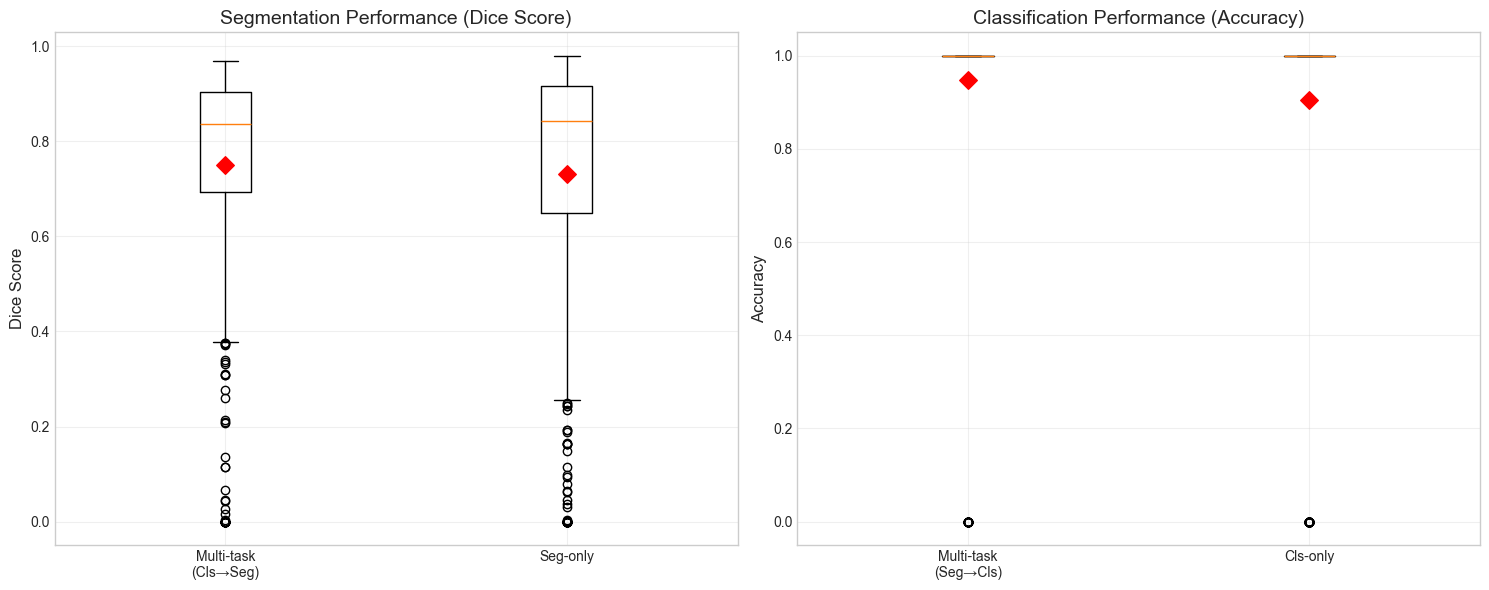

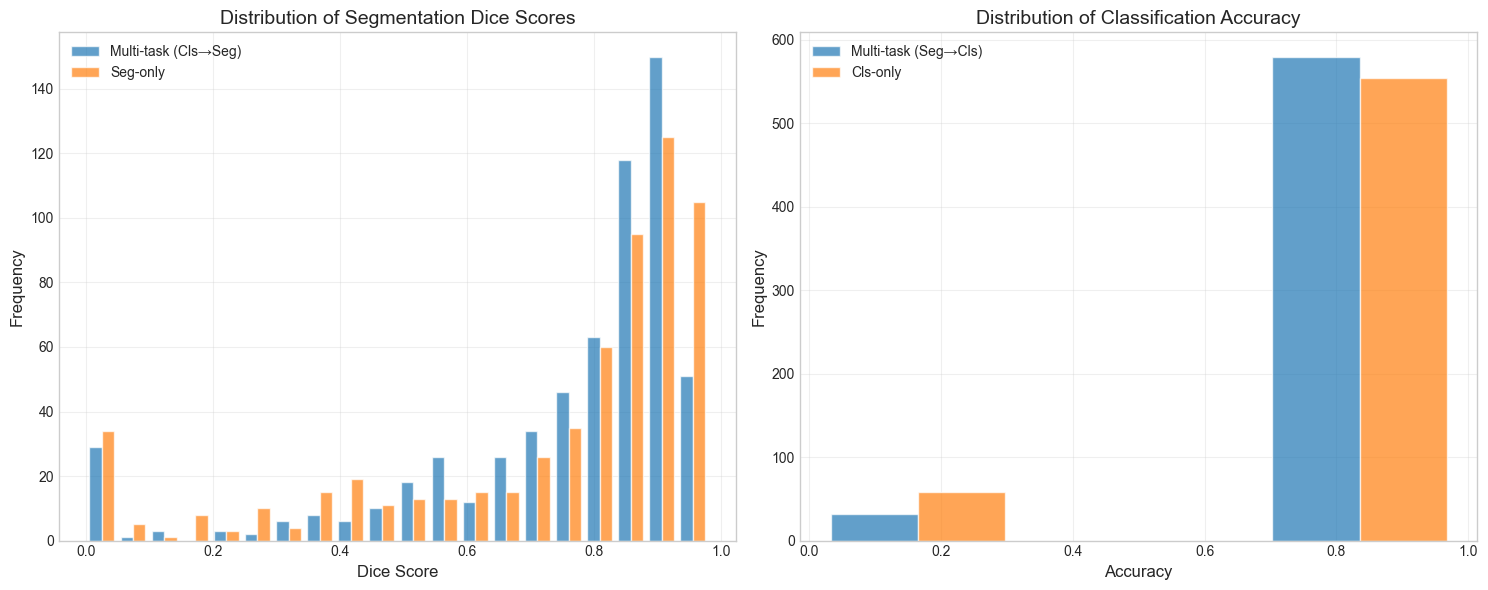


Summary of Results:
               Model           Task  Mean Score  Std Dev   Metric  P-value
Multi-task (Cls→Seg)   Segmentation    0.749020 0.230472     Dice 0.038300
   Segmentation-only   Segmentation    0.731074 0.266554     Dice 0.038300
Multi-task (Seg→Cls) Classification    0.947712 0.222606 Accuracy 0.000382
 Classification-only Classification    0.905229 0.292899 Accuracy 0.000382

Multi-task model improves segmentation by 2.45% over segmentation-only baseline
Multi-task model improves classification by 4.69% over classification-only baseline


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import random

# Set all seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move models to the appropriate device
model_cls_into_seg = model_cls_into_seg.to(device)
model_seg_into_cls = model_seg_into_cls.to(device)
model_seg = model_seg.to(device)
model_cls = model_cls.to(device)

# Set models to evaluation mode
model_cls_into_seg.eval()
model_seg_into_cls.eval()
model_seg.eval()
model_cls.eval()


# Custom Dice coefficient function
def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter = (p_flat * t_flat).sum(dim=1)
    summ = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice = (2 * inter + eps) / (summ + eps)
    return dice


# Function to compute segmentation metrics
def compute_seg_metrics(model, data_loader):
    dice_scores = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Computing segmentation metrics"):
            if len(batch) == 3:  # Multi-task data loader
                images, masks, _ = batch
            else:  # Seg-only data loader
                images, masks = batch

            # Move data to the appropriate device
            images = images.to(device)
            masks = masks.to(device)

            # For multi-task models, we need to handle the dual output
            if model == model_cls_into_seg or model == model_seg_into_cls:
                seg_logits, _ = model(images)
                seg_preds = torch.sigmoid(seg_logits)
            else:
                seg_preds = model(images)

            # Calculate Dice scores for each sample in the batch
            batch_dice = dice_coef(seg_preds, masks, thr=0.65)

            # Store individual scores
            for d in batch_dice:
                dice_scores.append(d.item())

    return dice_scores


# Function to compute classification metrics
def compute_cls_metrics(model, data_loader):
    accuracies = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Computing classification metrics"):
            if len(batch) == 3:  # Multi-task data loader
                images, _, labels = batch
            else:  # Cls-only data loader
                images, labels = batch

            # Move data to the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # For multi-task models, we need to handle the dual output
            if model == model_cls_into_seg or model == model_seg_into_cls:
                _, cls_logits = model(images)
            else:
                cls_logits = model(images)

            cls_preds = torch.argmax(cls_logits, dim=1)

            # Calculate accuracy for each sample
            batch_accuracy = (cls_preds == labels).float()

            # Store individual accuracies
            for acc in batch_accuracy:
                accuracies.append(acc.item())

            # Collect predictions and labels for F1 score calculation
            all_preds.extend(cls_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 score (macro)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracies, f1


# Compute metrics for all models
print("Computing segmentation metrics...")
seg_scores_cls_into_seg = compute_seg_metrics(model_cls_into_seg, test_loader_multi)
seg_scores_baseline = compute_seg_metrics(model_seg, test_loader_seg)

print("Computing classification metrics...")
cls_acc_seg_into_cls, cls_f1_seg_into_cls = compute_cls_metrics(model_seg_into_cls, test_loader_multi)
cls_acc_baseline, cls_f1_baseline = compute_cls_metrics(model_cls, test_loader_cls)

# Statistical analysis 1: Segmentation comparison
print("\n--- Statistical Analysis: Segmentation Performance ---")
print(
    f"Mean Dice Score - Multi-task (Cls into Seg): {np.mean(seg_scores_cls_into_seg):.4f} ± {np.std(seg_scores_cls_into_seg):.4f}")
print(f"Mean Dice Score - Segmentation Only: {np.mean(seg_scores_baseline):.4f} ± {np.std(seg_scores_baseline):.4f}")

# Paired t-test for segmentation
t_stat_seg, p_value_seg = stats.ttest_rel(seg_scores_cls_into_seg, seg_scores_baseline)
print(f"Paired t-test results: t={t_stat_seg:.4f}, p-value={p_value_seg:.4f}")
print(
    f"Conclusion: The difference is {'statistically significant' if p_value_seg < 0.05 else 'not statistically significant'} at p<0.05")

# Statistical analysis 2: Classification comparison
print("\n--- Statistical Analysis: Classification Performance ---")
print(
    f"Mean Accuracy - Multi-task (Seg into Cls): {np.mean(cls_acc_seg_into_cls):.4f} ± {np.std(cls_acc_seg_into_cls):.4f}")
print(f"Mean Accuracy - Classification Only: {np.mean(cls_acc_baseline):.4f} ± {np.std(cls_acc_baseline):.4f}")
print(f"F1 Score (Macro) - Multi-task (Seg into Cls): {cls_f1_seg_into_cls:.4f}")
print(f"F1 Score (Macro) - Classification Only: {cls_f1_baseline:.4f}")

# Paired t-test for classification accuracy
t_stat_cls, p_value_cls = stats.ttest_rel(cls_acc_seg_into_cls, cls_acc_baseline)
print(f"Paired t-test results (accuracy): t={t_stat_cls:.4f}, p-value={p_value_cls:.4f}")
print(
    f"Conclusion: The difference is {'statistically significant' if p_value_cls < 0.05 else 'not statistically significant'} at p<0.05")

# Set the style for matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

# Visualize the distribution of scores
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
bp1 = plt.boxplot([seg_scores_cls_into_seg, seg_scores_baseline], labels=['Multi-task\n(Cls→Seg)', 'Seg-only'])
plt.title('Segmentation Performance (Dice Score)', fontsize=14)
plt.ylabel('Dice Score', fontsize=12)
plt.grid(alpha=0.3)
# Add the mean as a red diamond
for i, d in enumerate([seg_scores_cls_into_seg, seg_scores_baseline], 1):
    plt.scatter(i, np.mean(d), color='red', marker='D', s=80, zorder=10)

plt.subplot(1, 2, 2)
bp2 = plt.boxplot([cls_acc_seg_into_cls, cls_acc_baseline], labels=['Multi-task\n(Seg→Cls)', 'Cls-only'])
plt.title('Classification Performance (Accuracy)', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(alpha=0.3)
# Add the mean as a red diamond
for i, d in enumerate([cls_acc_seg_into_cls, cls_acc_baseline], 1):
    plt.scatter(i, np.mean(d), color='red', marker='D', s=80, zorder=10)

plt.tight_layout()
plt.savefig('model_performance_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional visualization: Compare histograms of scores
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist([seg_scores_cls_into_seg, seg_scores_baseline], bins=20, alpha=0.7,
         label=['Multi-task (Cls→Seg)', 'Seg-only'])
plt.title('Distribution of Segmentation Dice Scores', fontsize=14)
plt.xlabel('Dice Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist([cls_acc_seg_into_cls, cls_acc_baseline], bins=[0, 0.33, 0.67, 1.0], alpha=0.7,
         label=['Multi-task (Seg→Cls)', 'Cls-only'])
plt.title('Distribution of Classification Accuracy', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a results DataFrame
results = {
    'Model': ['Multi-task (Cls→Seg)', 'Segmentation-only', 'Multi-task (Seg→Cls)', 'Classification-only'],
    'Task': ['Segmentation', 'Segmentation', 'Classification', 'Classification'],
    'Mean Score': [
        np.mean(seg_scores_cls_into_seg),
        np.mean(seg_scores_baseline),
        np.mean(cls_acc_seg_into_cls),
        np.mean(cls_acc_baseline)
    ],
    'Std Dev': [
        np.std(seg_scores_cls_into_seg),
        np.std(seg_scores_baseline),
        np.std(cls_acc_seg_into_cls),
        np.std(cls_acc_baseline)
    ],
    'Metric': ['Dice', 'Dice', 'Accuracy', 'Accuracy'],
    'P-value': [p_value_seg, p_value_seg, p_value_cls, p_value_cls]
}

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df.to_string(index=False))

# Calculate the percentage improvement
seg_improvement = (np.mean(seg_scores_cls_into_seg) - np.mean(seg_scores_baseline)) / np.mean(seg_scores_baseline) * 100
cls_improvement = (np.mean(cls_acc_seg_into_cls) - np.mean(cls_acc_baseline)) / np.mean(cls_acc_baseline) * 100

print(f"\nMulti-task model improves segmentation by {seg_improvement:.2f}% over segmentation-only baseline")
print(f"Multi-task model improves classification by {cls_improvement:.2f}% over classification-only baseline")